# Information Retrieval 1#
## Assignment 2: Retrieval models [100 points] 

## Functions for reading/writing files to do with TREC 

In [41]:
'''Import all relevant libraries'''

import logging
import sys
import os
import pyndri
import subprocess
from collections import defaultdict
import collections
import io
import time
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from scipy.stats import norm
import numpy as np
import scipy
import itertools
import pandas as pd
import gensim
import gensim.models
import pickle
from scipy.sparse import dok_matrix
from scipy import spatial
import gensim.models
import pyndri.compat
import copy
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import functools
from sklearn.externals import joblib

In [42]:
''' Routine provided with the assignment instructions. Needed to write run statistics to a file that can
be interpreterd by trec_eval'''

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """

    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))

In [43]:
def read_trec_results(from_path, filter_metrics=[]):
    
    '''Reads the results out put by the assignment_evals.sh bash script into a dictionary'''
    
    if not from_path[-4:] == '.txt': return None

    eval_data = defaultdict(dict)

    with open(from_path) as file_open:
        
        content = [line.strip().split() for line in file_open.readlines()]
        for metric, query, score in content:
            
            # If a filter is provided, skip those not in it
            if len(filter_metrics) > 0 and metric not in filter_metrics:
                continue
                
            file_name = from_path.split('/')[-1]
            eval_data[metric][query] = float(score)

    return eval_data

def read_trec_directory(from_path, filter_metrics=[]):

    '''Reads the results out put by the assignment_evals.sh bash script into a dictionary
     for an entire directory'''

    eval_data = {}
    for file_name in os.listdir(from_path):
        results = read_trec_results(from_path + file_name, filter_metrics=filter_metrics)

        if results:
            eval_data[file_name[:-4]] = results
    return eval_data

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [44]:
index = pyndri.Index('index/')
token2id, id2token, _ = index.get_dictionary()

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [46]:
def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                print("Max capacity reached... Breaking...")
                break

    return topics

### Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand how the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [47]:
'''Read the topic file and gather usefull statistics like document lengths, the inverted index and
query dictionary'''

start_time = time.time()

with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()

print('Total number of documents: ', num_documents)

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

# Used to build query/document relevance matrix in task 4
ext2int = defaultdict(int)

total_terms = 0

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)
    
    ext2int[ext_doc_id] = int_doc_id

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

# inverse of ext2int which was built in the loop above
int2ext = {i : ext for ext, i in ext2int.items()}

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Total number of documents:  164597
Gathering statistics about 456 terms.
Inverted index creation took 67.74565291404724 seconds.


In [48]:
print('Total number of queries: ', len(queries))
print('Average document length: ', avg_doc_length)

Total number of queries:  150
Average document length:  256.4381975370147


### Helper functions

In [49]:


"""Helper functions"""

def term_frequency(term_id, document_id):
    """
    Retrieves the term frequency a given word in a given document
    
    NB: depends on global variable 'inverted_index'
    
    :param term_id: The id of the word in question
    :param document_id: The internal document_id of the document in question
    """
    
    return inverted_index[term_id].get(document_id, 0)

def compute_BM25(doc_length, tf_raw, term_id, k=1.2, b=0.75):
    """
    Helper function to isolate computations shared by both 
    query + document vector versions and the original version of the BM25 method
    """
    
    inv_norm = doc_length / avg_doc_length
    document_freq = len(inverted_index[term_id])
    
    tf_normalized = tf_raw * (avg_doc_length / doc_length)

    # Note: slides are not particularly clear about whether to still use the normalized TF or not.
    # In this case we will continue with this normalized variable.
    tf = ((1.0 + k) * tf_normalized) / (k * ((b - 1.0) + b * (inv_norm)) + tf_normalized)

    idf = np.log(num_documents / document_freq)
    
    return tf * idf
    

def build_document_vector(document_id, vocabulary_size):
    '''
    Creates a vector of length V with the term frequency for each word in the vocabulary at its
    corresponding index
    
    :param document_id: The internal document id
    :param vocabulary_size: The number of words in the vocabulary
    '''
    
    vector = np.zeros(vocabulary_size)
    
    for token_id in inverted_index:
        documents_for_term = inverted_index[token_id]
        
        if document_id in documents_for_term:
            vector[token_id] = documents_for_term[document_id]
        
    return vector
        
def build_query_vector(query_terms, vocabulary_size):
    '''
    Creates a vector of length V with the term frequency for each word in the vocabulary at its
    corresponding index
    
    :param query_terms: A list of query term ids
    :param vocabulary_size: The number of words in the vocabulary
    '''
    
    vector = np.zeros(vocabulary_size)
    counts = collections.Counter(query_terms)
    
    for token_id in counts:
        vector[token_id] = counts[token_id]
        
    return vector

# Vector representation of the collection frequencies dictionary, used
# in the PLM function for fast matrix operations
collection_freq_matrix = np.zeros(len(id2token) + 1)
for key in sorted(collection_frequencies.keys()):
    if key > 0:
        collection_freq_matrix[key] = collection_frequencies[key]

### The Scoring Functions

#### TF-IDF and BM25
Defines the functions used to compute the TF-IDF, BM25 and corresponding query/document scores. Because we have more data on the documents than on the queries, the functions have seperate interfaces for both types (one takes an id, one takes a list of terms).

In [50]:
def score_similarity(query_terms, document_id, weight_fn = None, query_weight_fn = None):
    '''
    Scoring function for a document and a query
    
    :param query_terms: A list of query term ids
    :param document_id: The internal document id
    :param weight_fn: A function to re-weight the document vector
    :param query_weight_fn: A function to re-weight the query vector
    
    return: a score (float)
    '''
    
    vocab_size = len(id2token)
    
    # Create query vector
    # Create document vector
    doc_vec = build_document_vector(document_id, vocab_size)
    query_vec = build_query_vector(query_terms, vocab_size)
    
    # Combine query and document into a matrix with sparse representation (only save indices of non-zero entries)
    paired_matrix = np.array([query_vec, doc_vec])
    paired_matrix = sparse.csr_matrix(paired_matrix)
    
    if weight_fn and query_weight_fn:
        # nonzero() returns a tuple of two lists
        # 0 -> i dimension of non zero entries in array where i == 0 is the query vector
        # 1 -> j dimension of non zero entries in array array where j corresponds to the term_id
        document_type, term_ids = paired_matrix.nonzero()
        
        for document_type, term_id in zip(document_type, term_ids):
            if document_type == 0:
                # Re-weight query vector
                paired_matrix[document_type, term_id] = query_weight_fn(query_terms, term_id)
            else:
                # Re-weight document vecotr
                paired_matrix[document_type, term_id] = weight_fn(document_id, term_id)
    
    # Calculate similarity matrix
    similarity_matrix = cosine_similarity(paired_matrix)
    
    # Only first row is relevant (query document similarities)
    similarities = similarity_matrix[0, 1:]
    
    return similarities


def tfidf_query(query_terms, query_term_id):
    '''A seperate function to compute tf-idf score for a query word in a query'''
    counts = collections.Counter(query_terms)
    
    tf = np.log(1 + counts[query_term_id])
    
    df = len(inverted_index[query_term_id])
    idf = np.log(num_documents / df)
    
    score = tf * idf
    
    return score

def tfidf(int_document_id, query_term_id):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_term_id: the query term id (assuming you have split the query to tokens)
    """
    
    # Check: RAW COUNT OR NORMALIZED TF???
    tf = np.log(1 + term_frequency(query_term_id, int_document_id))
    
    # inverted_index[query_term_id] consists of all the documents this term appears in
    df = len(inverted_index[query_term_id])
    idf = np.log(num_documents / df)
    
    score = tf * idf 
    
    return score

# Here we will normalize the raw TF and a different kind of damping: (1 + k)/k
def BM25(int_document_id, query_term_id, k=1.2, b=0.75):
    """
    BM25 weight of a term
    
    :param int_document_id: the document id
    :param query_term_id: Token id of the term to be re-weighted
    
    """
    
    doc_length = len(index.document(int_document_id)[1])
    tf_raw = term_frequency(query_term_id, int_document_id)
    
    return compute_BM25(doc_length, tf_raw, query_term_id, k, b)

def BM25_query(query_terms, query_term_id, k=1.2, b=0.75):
    """
    Scoring function for a document and all terms of a single query
    
    :param int_document_id: the document id
    :param query_term_id: Token id of the term to be re-weighted
    
    """
    
    doc_length = len(query_terms) 
    counts = collections.Counter(query_terms)
    tf_raw = counts[query_term_id]
    
    return compute_BM25(doc_length, tf_raw, query_term_id, k, b)

def score_BM25(query_term_ids, int_document_id):
    '''
    Sum of unique query term scores of bm25 for the given document
    
    :param query_term_ids: ids of query terms
    :int_document_id: The ID of the document to be scored
    
    return: Document score for the given query (float)
    '''
    
    unique_terms = set(query_term_ids)
    doc_length = len(index.document(int_document_id)[1])
    tf_raw = term_frequency(query_term_id, int_document_id)
    
    # Sum over the set of all (unique) query terms
    score = np.sum([compute_BM25(doc_length, term_frequency(term_id, int_document_id), term_id) for term_id in unique_terms])
    
    return score

### Language Models

Here are the implementation for the following smoothing functions:

* Absolute Discounting
* Dirichlet-Prior Smoothing
* Jelinek-Mercer Smoothing

In [51]:
def absolute_discounting(int_document_id, query_term_id, delta=0.5):
    
    # TODO: figure our if tf should be raw or not. Max to ensure tf in range [0,1]
    tf_raw = max(term_frequency(query_term_id, int_document_id) - delta, 0)
    tot_nr_terms_in_doc = len(index.document(int_document_id)[1])
    unique_terms_in_doc = unique_terms_per_document[int_document_id]
    
    corpus_size = total_terms
    word_frequency = collection_frequencies[query_term_id]
    p_w_c = word_frequency / corpus_size
    
    score = tf_raw / tot_nr_terms_in_doc + ((delta * tot_nr_terms_in_doc) / tot_nr_terms_in_doc) * p_w_c

    return score


def dirichlet_prior_smoothing(int_document_id, query_term_id, mu=1000):
    ''' input: one document id, one query term id, mu
        output: for one query word , the dirichlet smoothed prior
    '''

    # Calculate the components of the model: tf, |d|, p(w|c)
    tf = term_frequency(query_term_id, int_document_id)
    document_length = document_lengths[int_document_id]
    p_wc = collection_frequencies[query_term_id]/total_terms
    
    signal = ((document_length/(document_length+mu))*(tf/document_length))
    background = ((mu/(document_length + mu))*p_wc)
    
    dir_smoothed_prior =  signal + background 
    
    return dir_smoothed_prior

def jelinek_mercer(int_document_id, query_term_id, lambd=0.5):
    """
    Calculate probabilty of a term by linearly interpolating with background language model.
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param lambd: the lambda paramter for the function
    """
    
    doc_length = len(index.document(int_document_id)[1])
    
    term_freq_doc = term_frequency(query_term_id, int_doc_id)
    term_freq_corpus = sum(inverted_index[query_term_id].values())
    
    signal = (term_freq_doc / doc_length)
    background = (term_freq_corpus / total_terms)
    
    return lambd * signal  + (1 - lambd) * background


def ml_query_word_language_model(query_term_ids):
    counts = collections.Counter(query_term_ids)
    return np.array([counts[term_id] / len(query_term_ids) for term_id in query_term_ids])

def unigram_prob(term_id, document_id):
    """
    Maximum Likelihood estimate of p(word|document_model)
    """
    tf = term_frequency(term_id, document_id)
    doc_length = len(index.document(document_id)[1])
    
    return tf / doc_length

def log_multinomial_query_language_model(query_term_ids, document_id, word_probability_func=unigram_prob):
    """
    Query-likelihood model assuming uniform document prior
    """

    counts = collections.Counter(query_term_ids)
    
    # sum_over_words_in_query( tf(w;d) * log( p(w|d) ) )
    return np.sum([counts[term_id]*np.log(word_probability_func(document_id, term_id)) 
                   for term_id in query_term_ids])

def kl_divergenge(query_term_ids, document_id, word_probability_func=unigram_prob):
    '''
    Kullback-Leiber divergence for query-language model and document-language model
    '''
    
    p_word_given_query = ml_query_word_language_model(query_term_ids)
    p_word_given_document = np.array([word_probability_func(term_id, document_id) for term_id in query_term_ids])
    
    return np.sum(p_word_given_query * np.log(p_word_given_document))

### Postition Based Language Model

In [52]:
def PLM_score(query_id_tokens, int_document_id, kernel_func, mu, sigma = 50, return_argmax=False):
    '''
    :param query_id_tokens: The query to be matched against
    :param int_document_id: The id of the document to score
    :param kernec_func: A kernel function that takes two indices (i,j)
    :param mu: parameter for dirichlet-prior smoothing
    :param sigma: the width of the kernel
    :param return_argmax: Indicate argmax mode (will return position of best-score instead of score)
     '''
    
    # document variables
    document = index.document(int_document_id)[1]
    doc_length = len(document)
    
    # Query id tokens without stopwords

    query_id_no_stopwrds = [word_id for word_id in query_id_tokens if word_id > 0]
    query_length = len(query_id_no_stopwrds)
        
    # Create a matrix to store all c(w,i)' values that matter
    c_wi_prime_matrix = np.zeros((query_length,doc_length))
    
    # Pre calculate kernel
    one_sided_kernel = [kernel_func(0, j) for j in range(doc_length)]
    kernel = np.array(list(reversed(one_sided_kernel))[:-1] + one_sided_kernel)
    
    # Loop over all positions in the document
    for i, word_id_i in enumerate(document):
        
        # If a word occurs in the query we should propagate its frequency to other positions
        for q, wrd in enumerate(query_id_no_stopwrds):
            
            if word_id_i == wrd:
                # Loop over all positions in the document as to have a distance from position i to j
                # for positions where i is a query word, and for which kernel(i,j) != 0
                for j in max_usefull_range(one_sided_kernel, i, doc_length):
                    c_wi_prime_matrix[q][j] += kernel[i - j]
    
    # Go through all positions in the document again now all the 
    # frequencies have been propagated
    Zi_vec = np.sum(c_wi_prime_matrix,axis=0)

    # Dirichlet smoothed probability of a query word on a position in the document
    p_wc_vec = collection_freq_matrix[np.array(query_id_tokens)] / total_terms
    p_wc_vec = np.expand_dims(p_wc_vec, axis=1)
    
    smooth_pos_values = (c_wi_prime_matrix + mu * p_wc_vec) / (Zi_vec + mu)
    
    # Calculate p(w|Q)
    q_language = ml_query_word_language_model(query_id_tokens) 
    
    # log( P(w|D,i) ) for all w, i pairs
    log_pos_values = np.log(smooth_pos_values)
    
    # Simplified KL-divergence formula (proportional to original for the same query)
    kl_divergence_scores = np.sum(q_language * log_pos_values.T, axis=1)
    
    # Offers the possibility to return the position of the maximum instead of the actual score.
    # this is used as a feature in LETOR.
    if return_argmax:
        argmax = np.argmax(kl_divergence_scores)
        if np.argmax:
            return argmax
        else:
            return doc_length
        
    else:
        return np.amax(kl_divergence_scores)

def max_usefull_range(kernel_vector, i, N):
    '''Compute the range of indices around position i in the doucment for which the 
       kernel has a postive value'''
    
    # index() throws an exception when the element is not in the array (in this case, for the guassian)
    try:
        max_distance = kernel_vector.index(0)
    except:
        max_distance = len(kernel_vector)
        
    minimum = max(0, i - max_distance)
    maximum = min(N, i + max_distance)
    
    return range(minimum, maximum)

'''Implementation of the kernel functions'''

def gaussian_kernel(i, j, sigma=50):
    return np.exp(-(i-j)**2 / (2 * sigma**2))

def triangle_kernel(i, j, sigma=50):
    return 1-abs(i - j)/sigma if abs(i - j) <= sigma else 0

def cosine_kernel(i, j, sigma=50):
    return 0.5 * (1 + np.cos((abs(i - j) * np.pi) / sigma)) if abs(i - j) <= sigma else 0

def circle_kernel(i, j, sigma=50):
    return np.sqrt(1-(abs(i - j)/sigma)**2) if abs(i - j) <= sigma else 0

def passage_kernel(i, j, sigma=50):
    return int(abs(i - j) < sigma/2)

### Bookkeeping

We need to have an account of the queries in the test/validation set and their corresponding top1000 TF-IDF ranked document list.

In [69]:
'''Read the validation/test files and save the ids into a list. This way we can easily check to which
set a query belong.'''

validation_queries_ids = []
with open('./ap_88_89/qrel_validation', 'r') as validation_queries:
    for line in validation_queries:
        query_id = line.split(' ')[0]
        if query_id not in validation_queries_ids:
            validation_queries_ids.append(query_id)
            
            

test_queries_ids = []
with open('./ap_88_89/qrel_test', 'r') as test_queries:
    for line in test_queries:
        query_id = line.split(' ')[0]
        if query_id not in test_queries_ids:
            test_queries_ids.append(query_id)

            
print('There are ',len(test_queries_ids),' test queries and ',len(validation_queries_ids),' validation queries')

There are  120  test queries and  30  validation queries


In [70]:
'''Save the ids of the top 1000 documents (ranked by TF-IDF) per query for the test and the validation set'''

top_1000_per_test_query = defaultdict(list)

with open('./run/already_run/TF-IDF.run', 'r') as top_docs_per_query:
    for line in top_docs_per_query:
        query_id = line.split(' ')[0]
        document_name = line.split(' ')[2]
        top_1000_per_test_query[query_id].append(document_name)

In [71]:
def run_retrieval(model_name, score_fn, model_type, query_set,name_set):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    :param model_type: indicates if a vector space or a proabilistic model is run. Takes either "Vector space"
                        or "Probabilistic"
    :param query_set: validation_queries_ids or test_queries_ids
    """

    run_out_path = '{}_{}.run'.format(model_name,name_set)
    if os.path.exists(run_out_path):
        print("File already exists; exiting...")
        return
    
    retrieval_start_time = time.time()

    print('Retrieving using', model_name)

    # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
    data = {}
    
    if model_name == 'TF-IDF':
        weight_fn = tfidf
        query_weight_fn = tfidf_query
    if model_name == 'BM25':
        weight_fn = BM25
        query_weight_fn = BM25_query
        
    counter = 1

    for query_id, query_terms in tokenized_queries.items():

        # skip queries of the set we are not interested in
        if query_id not in query_set:
            continue

        for int_doc_id in range(index.document_base(), index.maximum_document()):
            
            ext_doc_id, doc_token_ids = index.document(int_doc_id)
            
            if ext_doc_id not in top_1000_per_test_query[query_id]:
                continue

            # Only calculate score of document if it contains query words,
            # otherwise the score is zero for the vector based models
            length_query = len(query_terms)

            for i, query_term in enumerate(query_terms):
                # Only compute score if the query word is in the document
                
                if int_doc_id in inverted_index[query_term].keys():

                    # Calculate score for document and query terms
                    if model_type == "Vector space":
                        score = score_similarity(query_terms, int_doc_id, weight_fn, query_weight_fn)
                    elif model_type == "Probabilistic":
                        score = score_fn(query_terms, int_doc_id)
                                        
                
                    if query_id in data.keys():
                        data[query_id].append(tuple([float(score), str(ext_doc_id)]))
                    else:
                        data[query_id] = [((tuple([float(score),str(ext_doc_id)])))]

                    # If the document has a query word, than the score is calculated and appended by this point
                    break


                # If up until the last query word, the query word did not appear in the 
                # document, the score is the lowerst possible (-infinity)
                elif i == length_query-1:
                    score = -np.inf
                    if query_id in data.keys():
                        data[query_id].append(tuple([float(score), str(ext_doc_id)]))
                    else:
                        data[query_id] = [((tuple([float(score),str(ext_doc_id)])))]



        print('queries: ', counter,'/',len(query_set),'\t this took: ', time.time() - retrieval_start_time, ' seconds in total' )
        counter += 1
        
        # transform the list of tuples to a tuple of tuples, since this is the requered datastructue
        data[query_id] = tuple(data[query_id])

    # Write to file
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

### Analysis of task 1

#### Check which parameter values yield the highest values on the evaluation metrics for the language models

We show the  metrics NDCG@10, MAP@1000, Precision@5 and Recall@1000 for 'all' queries. 


In [ ]:
target_dir = 'run/TREC_results_on_validation_set/'

eval_data = read_trec_directory(target_dir)

model_names = [['jelinek_0.1_val_queries_len_C_is_num_words','lambda', '1', 'Jellinek-Mercer'], 
               ['jelinek_0.5_val_queries_len_C_is_num_words','lambda','5','Jellinek-Mercer' ], 
               ['jelinek_0.9_val_queries_len_C_is_num_words','lambda','9', 'Jellinek-Mercer'],
               ['dirichlet_500_val_queries_len_C_is_num_words','mu', '500','Dirichlet smoothing'],
               ['dirichlet_1000_val_queries_len_C_is_num_words','mu', '1000','Dirichlet smoothing'],
               ['dirichlet_1500_val_queries_len_C_is_num_words','mu', '1500', 'Dirichlet smoothing'],
               ['absolute_0.1_val_queries_len_C_is_num_words','delta','1', 'Absolute discounting'],
               ['absolute_0.5_val_queries_len_C_is_num_words','delta','5', 'Absolute discounting'],
               ['absolute_0.9_val_queries_len_C_is_num_words','delta','9', 'Absolute discounting']]

for model in model_names:
    print('With a %s of %s the %s had a NDCG@10 of %s, a MAP@1000 of %s a Precission @5 of %s and a Recall@1000 of %s'%(model[1], model[2], model[3],
                                                              eval_data[model[0]]['ndcg_cut_10']['all'],eval_data[model[0]]['map']['all'],
                                                            eval_data[model[0]]['P_5']['all'],eval_data[model[0]]['recall_1000']['all']))
    print()





Seeing that for all models the metrics don't differ much when adjusting the parameters we looked at run files manually. We found a clear difference in the scores when adjusting the parameters, but the rankings were almost identical per model. 

For two of the three models there is a slight difference in NDCG@10. We consider this the most important metric because it takes into account the fact that ranking the first few documents right is more important than ranking later documents right. 

For Dirichlet smoothing we thus choose a mu of 500 and for Absolute discounting we choose a delta of 5.

For Jellinek-Mercer we choose a lambda of 1. Note that all metrics for the three values of lambda are exactly the same and it seems to not matter.

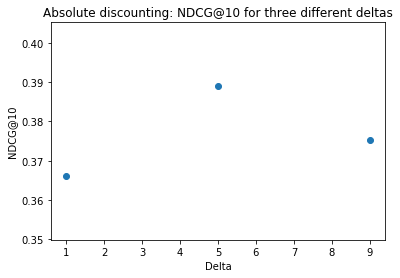

In [54]:
absdisc_ndcg = [0.3662, 0.3889, 0.3754]
absdisc_delta = [1, 5, 9]
plt.scatter(absdisc_delta, absdisc_ndcg)
plt.xlabel('Delta')
plt.ylabel('NDCG@10')
plt.title('Absolute discounting: NDCG@10 for three different deltas')
plt.show()

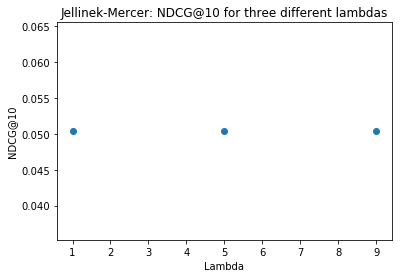

In [55]:
jelimerc_ndcg = [0.0504,0.0504,0.0504]
jelimerc_lambda = [1,5,9]

plt.scatter(jelimerc_lambda,jelimerc_ndcg)
plt.xlabel('Lambda')
plt.ylabel('NDCG@10')
plt.title('Jellinek-Mercer: NDCG@10 for three different lambdas')
plt.show()

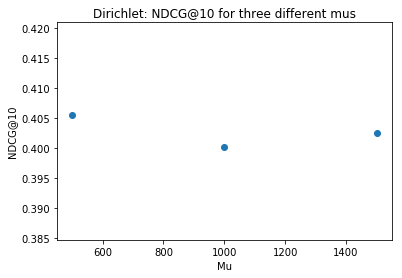

In [56]:
dirismooth_ndcg = [0.4055,0.4002,0.4026]
dirismooth_mu = [500,1000,1500]

plt.scatter(dirismooth_mu, dirismooth_ndcg)
plt.xlabel('Mu')
plt.ylabel('NDCG@10')
plt.title('Dirichlet: NDCG@10 for three different mus')
plt.show()

### The Positional based language model (PLM)
The PLM only has to be run on the top 1000 documents per query (ranked by the TF-IDF). We run it for all values of mu on the test queries instead of just for the mu of 1500. We do this to see if there might be a difference for this model or maybe if a subset is used. If a difference is found, we run the the other language models again, but just on these top-1000 queries TODO


### Test which PLM $\mu$-kernel combination works best on the validation set

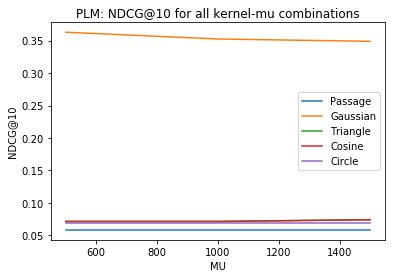

The best kernel is the Gaussian kernel. The ndcg@10 for the gaussian kernels are: [0.3629, 0.3525, 0.3489]
The best kernel-mu combination is thus a gaussian kernel with a mu of 500


In [58]:
PLM_mus = [500,1000,1500]

eval_data_PLM = read_trec_directory('run/TREC_results_on_validation_set/PLM/')

passage_ndcg10 = [float(eval_data_PLM['PLM_PASSAGE_500_']['ndcg_cut_10']['all']),
                 float(eval_data_PLM['PLM_PASSAGE_1000_']['ndcg_cut_10']['all']),
                 float(eval_data_PLM['PLM_PASSAGE_1500_']['ndcg_cut_10']['all'])]

gaussian_ndcg10 = [float(eval_data_PLM['PLM_GAUS_500_']['ndcg_cut_10']['all']),
                 float(eval_data_PLM['PLM_GAUS_1000_']['ndcg_cut_10']['all']),
                 float(eval_data_PLM['PLM_GAUS_1500_']['ndcg_cut_10']['all'])]

triangle_ndcg10 = [float(eval_data_PLM['PLM_TRIANGLE_500_']['ndcg_cut_10']['all']),
                 float(eval_data_PLM['PLM_TRIANGLE_1000_']['ndcg_cut_10']['all']),
                 float(eval_data_PLM['PLM_TRIANGLE_1500_']['ndcg_cut_10']['all'])]

cosine_ndcg10 = [float(eval_data_PLM['PLM_COSINE_500_']['ndcg_cut_10']['all']),
                 float(eval_data_PLM['PLM_COSINE_1000_']['ndcg_cut_10']['all']),
                 float(eval_data_PLM['PLM_COSINE_1500_']['ndcg_cut_10']['all'])]

circle_ndcg10 = [float(eval_data_PLM['PLM_CIRCLE_500_']['ndcg_cut_10']['all']),
                 float(eval_data_PLM['PLM_CIRCLE_1000_']['ndcg_cut_10']['all']),
                 float(eval_data_PLM['PLM_CIRCLE_1500_']['ndcg_cut_10']['all'])]



plt.plot(PLM_mus, passage_ndcg10, label = 'Passage')
plt.plot(PLM_mus, gaussian_ndcg10, label = 'Gaussian')
plt.plot(PLM_mus, triangle_ndcg10, label = 'Triangle')
plt.plot(PLM_mus, cosine_ndcg10, label = 'Cosine')
plt.plot(PLM_mus, circle_ndcg10, label = 'Circle')

plt.xlabel('MU')
plt.ylabel('NDCG@10')
plt.title('PLM: NDCG@10 for all kernel-mu combinations')
plt.legend()
plt.show()
print('The best kernel is the Gaussian kernel. The ndcg@10 for the gaussian kernels are:', gaussian_ndcg10)
print('The best kernel-mu combination is thus a gaussian kernel with a mu of 500')

### Significance testing

In [59]:
def create_datastructure(queryset, model = None):
    '''
    input: queryset: test or validation
    optional input: create it for a specific model
    output: dict of dict of dicts. All trec output for either the test or validation TREC results
    
    '''
    
    data = defaultdict(lambda: defaultdict(dict))
    
    if queryset == 'validation':
        path = 'run/already_run'
    if queryset == 'test':
        path = 'run/TREC_results_on_test_set'

    for file in os.listdir(path):
        if file[-4:] == ".txt":
            chunks = file.split('_')
            if queryset == 'test':
                model_name = chunks[0]
                print(model_name)
            if queryset == 'validation':
                if chunks[2] or chunks[3] == 'val':
                    if chunks[0] == 'PLM':
                        model_name = chunks[0]+chunks[1]+chunks[2]
                    else:
                        model_name = chunks[0]+chunks[1]
                    model_name = chunks
            
            with open(path +'/'+ file) as file:
                content = [line.strip().split() for line in file.readlines()]
                for metric, query, score in content:
                    data[model_name][metric][query] =float(score)

    return data


def pairwise_significance_tests(test_data, metric = None, alpha = 0.05):
    '''
    input: 
    - the TREC test values of all models.
    
    optional input: 
    - specific metric to perform the t-test on. If none => it will be performed on all
    - the alpha value 
    
    output: 
    - print statement(s) with t-tests
    - txt file with the mean difference and whether its significant or not
    
    '''
    
    models = ['BM25','TF-IDF', 'jelinek', 'dirichlet','absolute','W2V']
#     metrics = ['P_5','ndcg_cut_10','map','recall_1000']
    metrics = ['ndcg_cut_10']
     
    # Correctig alpha because of the multiple comparison problem
    m= calculate_m() # number of hypothesis tests 
    
    print('The number of hypotheses that will be tested is:', m)
    
    # Sidak correction (slightly less conservative, solves for family wise err rate)
    sidak_alpha = 1-(1-alpha)**(1/m)
    
    # Bonferoni correction (free of dependence and distrivutional assumptions)
    bonferoni_alpha = alpha/m 
    
    alphas = [bonferoni_alpha]
    # empty it again
    tested_combinations = []
        
    # Test all model combinations
    statistically_different = []
    for metric in metrics:
        
        #headers
        headers = ['BM25','TF-IDF', 'Jellinek-Mercer', 'Dirichlet',
                      'Absolute-Discounting','Word2Vec']

        no_cols = len(headers)

        file = open(metric+'_t-tests.txt','w')

        for counter1, model_1 in enumerate(models):             

            for counter2, model_2 in enumerate(models):
                
                if counter1 == 0 and counter2 ==0:
                    file.write(" ".join(headers))
                    row = []
                    file.write("\n")
                    
                print(counter2,no_cols)
                print(row)

                if model_1 == model_2:
                    row.append('x')
                    if counter1==no_cols-1 and counter2 == no_cols-1:
                        print('writing',row)
                        
                        # Append row
                        file.write(" ".join(row))
                        row = []
                        file.write("\n")
                        
                    continue
                
                print(metric, model_1, model_2)
                t_test = scipy.stats.ttest_rel(list(test_data[model_1][metric].values())[:-1],
                                               list(test_data[model_2][metric].values())[:-1])
                t_statistic = t_test[0]
                p_value = t_test[1]

                # append to tested combinations so it won't test the same thing twice
#                 tested_combinations.append((model_1,model_2,metric))
#                 tested_combinations.append((model_2,model_1,metric))

                # Print for the different corrections
                for num, corrected_alpha in enumerate(alphas):
                    if num == 0:
                        correction_method = 'Bonferoni'
                    if num == 1:
                        correction_method = 'Sidak'
                    print()
                    print('______________________________________________')
                    print("The t-test of %s and %s for the %s metric, conducted with an alpha of %f and a %s corrected alpha of %.4f has a p-value of: %.4f"%(model_1, model_2, metric, float(alpha),correction_method, float(corrected_alpha), float(p_value)))

                    if p_value < corrected_alpha:
                        print('The means of these models for this metric are thus statistically significant different')
                        statistically_different.append((model_1, model_2, metric, correction_method))
                        difference = (float(list(test_data[model_1][metric].values())[-1])-float(list(test_data[model_2][metric].values())[-1]))
                        if str(difference)[0] == '-':
                            row.append(str(difference)[:7]+'*')
                        else:
                            row.append(str(difference)[:6]+'*')
                    else:
                        print('The means of these models for this metric are thus NOT statistically significant different')
                        difference = (float(list(test_data[model_1][metric].values())[-1])-float(list(test_data[model_2][metric].values())[-1]))
                        if str(difference)[0] == '-':
                            row.append(str(difference)[:7])
                        else:
                            row.append(str(difference)[:6])
                        print()
                        print('The difference in means of %s and %s is: %.4f - %.4f = %.4f '%(model_1, model_2,
                                                                       float(list(test_data[model_1][metric].values())[-1]),
                                                                        float(list(test_data[model_2][metric].values())[-1]),
                                                                          float(list(test_data[model_1][metric].values())[-1])-float(list(test_data[model_2][metric].values())[-1])))
                if counter2 == no_cols-1:
                    print('writing',row)
                    # Append row
                    file.write(" ".join(row))
                    row = []
                    file.write("\n")
    return statistically_different, df
    
    
def calculate_m():
    
    m=0
    
    # First calculate m in the ugliest way thinkable
    # Test all model combinations
    models = ['BM25','TF-IDF', 'jelinek', 'dirichlet','absolute','PLM','W2V','LSI','LSItfidf','LDA']
    metrics = ['P_5','ndcg_cut_10','map','recall_1000']
    tested_combinations = []
    for metric in metrics:
        for model_1 in models:
            for model_2 in models:
                if model_1 != model_2 and (model_1,model_2,metric) not in tested_combinations and (model_2,model_1,metric) not in tested_combinations:
                    # append to tested combinations so it won't test the same thing twice
                    tested_combinations.append((model_1,model_2,metric))
                    tested_combinations.append((model_2,model_1,metric))
                    
                    # another hypothesis test
                    m +=1
    
    ## However, PLM, LSI, LSItfidf, LDA and the Learning to rank model will not be tested against
    # 'BM25','TF-IDF', 'jelinek', 'dirichlet','absolute' and W2V. Thus these tests must be subtracted from m.
    models1= ['BM25','TF-IDF', 'jelinek', 'dirichlet','W2V']
    models2 = ['PLM','LSI','LSItfidf','LDA','LETOR']
    
    will_not_be_tested = len(list(itertools.product(models1, models2)))
    m_adjusted = m-will_not_be_tested

    return m_adjusted

def specific_query_testing():
    return

### Task 2: Latent Semantic Models (LSMs) [15 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

In [60]:
'''Create mapping between external document id and indexes of objects in this task'''

start_time = time.time()
docid_2_docnr = {}
for document_idx in range(index.document_base(), index.maximum_document()):
    docid_2_docnr[index.document(document_idx)[0]] = document_idx
    
print(time.time() - start_time)

8.807965993881226


In [61]:
'''This is the connector that ports Pyndri objects in a Gensim-friendly way.
Source: http://www.pythonexample.com/code/gensim-pyro/
Only updated return values from _doc2bow func; swapped key, value'''

class LDALSISentences(gensim.interfaces.CorpusABC):
    # Dictionary through task 2 = vocabulary
    def __init__(self, index, dictionary, max_documents=None):
        assert isinstance(index, pyndri.Index)
 
        self.index = index
        self.dictionary = dictionary
 
        self.max_documents = max_documents
 
    def _maximum_document(self):
        if self.max_documents is None:
            return self.index.maximum_document()
        else:
            return min(
                self.max_documents + self.index.document_base(),
                self.index.maximum_document())
 
    def _doc2bow(self, doc):
 
        di = collections.defaultdict(int)
 
        for token_id in doc:
            di[token_id] += 1
    
        return [(key, value) for key, value in di.items()]
 
    def __iter__(self):

        for int_doc_id in range(self.index.document_base(),
                                self._maximum_document()):
            ext_doc_id, tokens = self.index.document(int_doc_id)
 
            tokens = tuple(
                token_id
                for token_id in tokens
                if token_id > 0 and token_id in self.dictionary)

            yield self._doc2bow(tokens)
 
    def __len__(self):
        return self._maximum_document() - self.index.document_base()
    
# Use this class if you want to create a gensim BOW representation, without passing a Pyndri index
class MyConnecterForTop1000(gensim.interfaces.CorpusABC):
    
    """
    :index = a list of lists; where each list is a document
    :dictionary = a dictionary of token2id and id2token
    """
    
    def __init__(self, index, dictionary, max_documents=None):
        
        self.index = index
        self.dictionary = dictionary
 
        self.max_documents = max_documents
    
    def _doc2bow(self, doc):
 
        di = collections.defaultdict(int)
 
        for token_id in doc:
            di[token_id] += 1
    
        return [(key, value) for key, value in di.items()]
    
    def __iter__(self):

        for ext_doc_id, tokens in self.index:
 
            tokens = tuple(
                token_id
                for token_id in tokens
                if token_id > 0 and token_id in self.dictionary)

            yield self._doc2bow(tokens)
    
    def __len__(self):
        return len(self.index)

In [62]:
def LSI(corpus, dictionary, num_topics, store=False):
    
    lsi = gensim.models.lsimodel.LsiModel(corpus, id2word=dictionary, num_topics=num_topics)
    
    if store == True:
        file_name = ""
        full_file_name = file_name + ".p"
        
        if full_file_name.exists():
            print("This file already exists, pick another...")
            return
        
        pickle.dump(lsi, open(full_file_name, "wb"))
        
    return lsi


def LDA(corpus, dictionary, num_topics, update_every=1, chunksize=500, passes=5, store=False):
    
    #print("Start training LDA model...")
    lda = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                          id2word=dictionary, 
                                          num_topics=num_topics, 
                                          update_every=update_every, 
                                          chunksize=chunksize, 
                                          passes=passes)
    
    #print("Done training")
    
    if store == True:
        file_name = "lda_model_tfidf100"
        full_file_name = file_name + ".p"
        
        if full_file_name.exists():
            print("This file already exists, pick another...")
            return
        
        try:    
            pickle.dump(lda, open(full_file_name, "wb" ))
        except:
            print("Storing LDA model failed...")
        
    return lda
    
def print_model_topics(model, nr_of_topics, words_per_topic):
    print(model.print_topics(nr_of_topics, num_words=words_per_topic))
    return

In [63]:
# Step 0: Convert corpus into gensim dictionary object
def init_corpus(store=False):
    
    #index = pyndri.Index('index/')
    print("Building dictionary...")
    dictionary = pyndri.extract_dictionary(index)
    
    print("Building corpus...")
    corpus = LDALSISentences(index, dictionary)
    
    # For our own TF IDF, skip those doc ids that are not in given list.
    print("Building TF-Corpus...")
    corpus = [doc for doc in corpus]
    
    print("Storing dictionary and corpus...")
    
    if store == True:
        pickle.dump(dictionary, open( "dictionary.p", "wb" ))
        pickle.dump(corpus, open( "corpus_tf.p", "wb" ))
    
    return corpus, dictionary

# Create our own TFIDF corpus based on task 1
def transform_corpus(corpus, store=False):
    print("Initializing TFIDF model...")
    tfidf_model = gensim.models.TfidfModel(corpus)
    
    print("Training TFIDF model...")
    corpus_tfidf = tfidf_model[corpus]
    
    if store == True:
        pickle.dump(corpus_tfidf, open( "corpus_tfidf.p", "wb" ))
    
    return corpus_tfidf

def load_from_pickle(corp_bow="", q_bow="", sem_model="", sim_model=""):
    
    corpus_bow, query_bows, semantic_model, similarity_model = None, None, None, None
    
    if corp_bow != "":
        try:
            print("Loading corpus BOW: %s...".format(corp_bow))
            with open(corp_bow, 'rb') as f:
                corpus_bow = pickle.load(f)
            print("Load successful")
        except:
            print("Load unsuccesful")
            
    if q_bow != "":
        try:
            print("Loading query BOW: %s...".format(q_bow))
            with open(q_bow, 'rb') as f:
                query_bows = pickle.load(f)
            print("Load successful")
        except:
            print("Load unsuccessful")
    
    if sem_model != "":
        try:
            print("Loading semantic model: %s...".format(sem_model))
            with open(sem_model, 'rb') as f:
                semantic_model = pickle.load(f)
            print("Load successful")
        except:
            print("Load unsuccessful")
        
    if sim_model != "":
        try:
            print("Loading similarity model: %s...".format(sim_model))
            with open(sem_model, 'rb') as f:
                similarity_model = pickle.load(f)
            print("Load successful")
        except:
            print("Load unsuccessful")
        
    return corpus_bow, query_bows, semantic_model, similarity_model


# Step 1: Build a representation q of the query
def query_representation(dictionary):
    
    with open('./ap_88_89/topics_title', 'r') as f_topics:
        queries = parse_topics([f_topics])
        
    tokenized_queries = {
        query_id: [dictionary.translate_token(token)
                   for token in index.tokenize(query_string)
                   if dictionary.has_token(token)]
        for query_id, query_string in queries.items()}

    unique_query_ids = set(
        query_term_id
        for query_term_ids in tokenized_queries.values()
        for query_term_id in query_term_ids)
    
    #print(tokenized_queries)
    
    query_bows = {}
    
    for query_nr in tokenized_queries.keys():
        query_bows[query_nr] = dictionary.doc2bow(tokenized_queries[query_nr])
    
    return tokenized_queries, unique_query_ids, query_bows

def init_similarity_model(model, corpus, num_features=300, store=False):
    
    sim_index = gensim.similarities.MatrixSimilarity(model[corpus], num_features=num_features)
    
    if store == True:
        pickle.dump(sim_index, open("sim_index_lsi_tf.p", "wb"))
    
    return sim_model
    
# Generates a weird error:
def gensim_similarity(sim_model, model, query_bow, top_num=0):
    
    query_representation = model[query_bow]
    
    similarities = sim_model[query_representation]
    
    sorted_similarities = sorted(enumerate(similarities), key=lambda item: -item[1])
    
    if top_num != 0:
        sorted_similarities = sorted_similarities[:top_n]

    return sorted_similarities

def get_tfidf_ranking_list():
    top_1000_per_test_query = defaultdict(list)

    with open('run/already_run/TF-IDF.run', 'r') as top_docs_per_query:
        for line in top_docs_per_query:
            query_id = line.split(' ')[0]
            document_name = line.split(' ')[2]
            top_1000_per_test_query[query_id].append(document_name)
            
    return top_1000_per_test_query

In [64]:
# Work here to load all documents
def task_2_lsi(model_name, num_topics_lsi, num_topics_lda, run=False, mode="validation", retfidf=False):
    
    if task_2 == False:
        return
    
    run_out_path = '{}.run'.format(model_name)
    
    num_features_lsi = num_topics_lsi
    num_features_lda = num_topics_lda
    start_time = time.time()
    
    # Fetch the top 1000 ranking using our own implementation of TF-IDF (task 1)
    tfidf1000 = get_tfidf_ranking_list()

    # Narrowing queries down to appropriate dataset:
    if mode == "validation":
        validation_set = {}
        for query_nr in tfidf1000.keys():
            if str(query_nr) in validation_queries_ids:
                validation_set[query_nr] = tfidf1000[query_nr]
        print("Number of queries: ", len(validation_set))
    else:
        test_set = {}
        for query_nr in tfidf1000.keys():
            if str(query_nr) in test_queries_ids:
                validation_set[query_nr] = tfidf1000[query_nr]
        print("Number of queries: ", len(test_set))
    
    # Get the dictionary of the entire index:
    dictionary = pyndri.extract_dictionary(index)
    
    # Get the query bow representations:
    _, _, query_bows = query_representation(dictionary)
    
    data = {}
    
    # For each query...
    for i, query_nr in enumerate(query_bows.keys()):
        
        if i % 5 == 0:
            print("Queries processed: ", i, " at ", time.time() - start_time, " seconds...")
        
        if mode == "validation":
            if query_nr not in validation_set.keys():
                print("Query nr ", query_nr, "not in validation set, skipping...")
                continue 
            else:
                original_ranking = validation_set[query_nr]
        else:
            if query_nr not in test_set.keys():
                print("Query nr ", query_nr, "not in test set, skipping...")
                continue
            else:
                original_ranking = test_set[query_nr]
        
        query_bow = query_bows[query_nr]
        
        # Get the list of documents that will build the corpus
        doc_list = [index.document(docid_2_docnr[doc]) for doc in original_ranking]
        
        query_corpus = MyConnecterForTop1000(doc_list, dictionary)
        
        #TF-IDF transformation:
        if retfidf == True:
            query_corpus = transform_corpus(query_corpus)
        
        # Build LSI model for the query's corpus:
        # The idea here is to narrow the topic-creating scope down to 
        lsi = gensim.models.lsimodel.LsiModel(query_corpus, id2word=dictionary, num_topics=num_topics_lsi)
        
        # Build similarity matrix for LSI:
        sim_index = gensim.similarities.MatrixSimilarity(lsi[query_corpus], num_features=num_features_lsi)
        
        # Find LSI representation for query:
        query_lsi = lsi[query_bow]

        # Find similarities using the index matrix and the 
        similarities = sim_index[query_lsi]
        
        data[query_nr] = tuple(zip(similarities, original_ranking))
        
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)
    
    return data

In [ ]:
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

def task_2_lda(model_name, num_topics_lsi, num_topics_lda, run=False, mode="validation"):
    
    if task_2 == False:
        return
    
    run_out_path = '{}.run'.format(model_name)
    
    num_features_lsi = num_topics_lsi
    num_features_lda = num_topics_lda
    start_time = time.time()
    
    # Fetch the top 1000 ranking using our own implementation of TF-IDF (task 1)
    tfidf1000 = get_tfidf_ranking_list()

    # Narrowing queries down to appropriate dataset:
    if mode == "validation":
        validation_set = {}
        for query_nr in tfidf1000.keys():
            if str(query_nr) in validation_queries_ids:
                validation_set[query_nr] = tfidf1000[query_nr]
        print("Number of queries: ", len(validation_set))
    else:
        test_set = {}
        for query_nr in tfidf1000.keys():
            if str(query_nr) in test_queries_ids:
                validation_set[query_nr] = tfidf1000[query_nr]
        print("Number of queries: ", len(test_set))
    
    # Get the dictionary of the entire index:
    dictionary = pyndri.extract_dictionary(index)
    
    # Get the query bow representations:
    _, _, query_bows = query_representation(dictionary)
    
    data = {}
    
    # For each query...
    for i, query_nr in enumerate(query_bows.keys()):
        
        if i % 5 == 0:
            print("Queries processed: ", i, " at ", time.time() - start_time, " seconds...")
        
        if mode == "validation":
            if query_nr not in validation_set.keys():
                #print("Query nr ", query_nr, "not in validation set, skipping...")
                continue 
            else:
                original_ranking = validation_set[query_nr]
        else:
            if query_nr not in test_set.keys():
                #print("Query nr ", query_nr, "not in test set, skipping...")
                continue
            else:
                original_ranking = test_set[query_nr]
        
        query_bow = query_bows[query_nr]
        
        # Get the list of documents that will build the corpus
        doc_list = [index.document(docid_2_docnr[doc]) for doc in original_ranking]
        
        query_corpus = MyConnecterForTop1000(doc_list, dictionary)
        
        # Build LSI model for the query's corpus:
        lda = LDA(query_corpus, dictionary, num_topics=num_topics_lda, update_every=1, chunksize=500, passes=5)
        
        # Build similarity matrix for LSI:
        sim_index = gensim.similarities.MatrixSimilarity(lda[query_corpus], num_features=num_features_lda)
        
        # Find LSI representation for query:
        query_lda = lda[query_bow]

        # Find similarities using the index matrix and the 
        similarities = sim_index[query_lda]
        
        data[query_nr] = tuple(zip(similarities, original_ranking))
        
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)
    
    return data

sims = task_2("LDA_validation_topics_100", 100, 100, run=True, mode="validation")
print("1 done")

### Task 3:  Word embeddings for ranking [20 points] (open-ended) ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).
   
This is an open-ended task. It is left up you to decide how you will combine word embeddings to derive query and document representations. Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt.tar.gz). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [ ]:
def build_w2v_model(file="", train=False, epochs=5):
    
    if train == True:
        word2vec = gensim.models.Word2Vec(
        size=300,  # Embedding size
        window=5,  # One-sided window size
        sg=True,  # Skip-gram.
        min_count=5,  # Minimum word frequency.
        sample=1e-3,  # Sub-sample threshold.
        hs=False,  # Hierarchical softmax.
        negative=10,  # Number of negative examples.
        iter=1,  # Number of iterations.
        workers=8,  # Number of workers.
    )

        print("Fetching dictionary...")
        dictionary = pyndri.extract_dictionary(index)

        print("Fetching sentences...")
        sentences = pyndri.compat.IndriSentences(index, dictionary)

        print("building vectors...")
        %time word2vec.build_vocab(sentences, trim_rule=None)

        print("Training...")
        w2v_models = [word2vec]

        N_EPOCHS = epochs

        for epoch in range(N_EPOCHS):
            print('Epoch ', epoch)

            w2v_model = copy.deepcopy(w2v_models[-1])
            w2v_model.train(sentences, total_examples=word2vec.corpus_count, epochs=1)

            w2v_models.append(w2v_model)
        
    else:
        if file != "":
            with open(file, 'rb') as f:
                w2v_model = pickle.load(f)
        else:
            print("Enter file name or train the model (i.e set train=True)")
            return None
    
    return w2v_model
        
        
def build_query_vectors(word2vec, dictionary, mode="validation"):
    
    dictionary = pyndri.extract_dictionary(index)
    
    with open('./ap_88_89/topics_title', 'r') as f_topics:
        queries = parse_topics([f_topics])
        
    tokenized_queries = {
        query_id: [token
                   for token in index.tokenize(query_string)
                   if dictionary.has_token(token)]
        for query_id, query_string in queries.items()}
    
    not_found = []
    query2vec = {}
    for query in tokenized_queries.keys():
        words = np.array(tokenized_queries[query])
        
        embeddings = []
        for word in words:
            try:
                embeddings.append(word2vec.wv[word])
            except:
                not_found.append(word)
        
        query2vec[query] = np.average(embeddings, axis=0)
        
    return query2vec, not_found

def build_doc_vectors(w2v, sentences, not_found=[], mode="validation"):
    
    doc2vec = {}
    
    for i, sentence in enumerate(sentences):
        if i % 50000 == 0:
            print(i, "sentences processed")
        
        embeddings = []
        for word in sentence:
            try:
                embeddings.append(word2vec.wv[word])
            except:
                not_found.append(word)
                
        doc2vec[index.document(i + 1)[0]] = np.average(embeddings, axis=0)
 
    return doc2vec, not_found

def get_ranking(model_name, query2vec, doc2vec, mode="validation"):
    
    ranking_by_query = {}
    
    if mode == "validation":
        queries = [query for query in query2vec.keys() if query in validation_queries_ids]
    else:
        queries = [query for query in query2vec.keys() if query in test_queries_ids]
        
    issues = []
    ranking = defaultdict(list)
    for i, query in enumerate(queries):
        print("Query nr", i, "/", len(queries), )
        q_embedding = query2vec[query]
        
        for document in doc2vec.keys():
            d_embedding = doc2vec[document]
            if d_embedding.shape == (300,):
                score = 1 - spatial.distance.cosine(q_embedding, d_embedding)
            else:
                issues.append(document)
                score = 0.0
            
            ranking[query].append((score, document))

    run_out_path = '{}.run'.format(model_name)

    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=ranking,
            out_f=f_out,
            max_objects_per_query=1000)
    
    return ranking, issues

# %time w2v_model2 = build_w2v_model(file="self_trained_word2vec.pickle")

#%time query2vec, not_found = build_query_vectors(w2v_model, dictionary)

#%time doc2vec, words_not_found = build_doc_vectors(w2v_model, sentences, not_found=not_found)

#%time ranking, doc_issues = get_ranking(query2vec, doc2vec)

### Task 4: Learning to rank (LTR) [15 points] (open-ended) ###

In this task you will get an introduction into learning to rank for information retrieval.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1, Task 2 and Task 3 as features. Think about other features you can use (e.g. query/document length). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

You are adviced to start some pointwise learning to rank algorithm e.g. logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set. More advanced learning to rank algorithms will be appreciated when grading.

In [72]:
def read_run(path_to_run, top1000, empty_queries):
    '''
    Read document scores from a .run file
    
    :param path_to_run: where to find the .run file
    '''
    
    print("reading from {}".format(path_to_run))
    
    scores = defaultdict(dict)
    
    with open(path_to_run) as run_file:
        for i, line in enumerate(run_file.readlines()):
            query_id, _, ext_doc_id, document_rank, score, label = line.split()
            
            # Skip q/d pairs that don't share words
            if score == '0' or score == '-inf':
                continue
            
            # Only look at top1000 document for the query
            if top1000 and not ext_doc_id in top_1000_per_test_query[query_id]:
                continue
                
            scores[int(query_id)][ext2int[ext_doc_id]] = float(score)
    
    filter_queries = list(scores.keys()) if empty_queries else None
    
    return matrix_from_two_level_dict(scores, filter_top_1000=top1000, filter_queries=filter_queries)

def unique_docs_top_1000(top_1000):
    
    '''Return the set of unique documents that occur in one of the top1000 for at least one of the queries'''
    unique_top_docs = set()
    for top in top_1000.values():
        for doc in top:
            unique_top_docs.add(ext2int[doc])
    return unique_top_docs
    
def indices_of_all_top_1000(top_1000):
    '''Get the indices of the documents that occur in a top1000'''
    
    unique_top_docs = unique_docs_top_1000(top_1000)      
    indices = np.array(sorted(list(unique_top_docs))) - 1
    
    return indices
    
def build_relevance_matrix(path_to_relavance_labels, top1000, empty_queries, sparse=True):
    '''
    Constructs a sparse matrix where the relevant query/document pairs are 1's and the rest 0's
    
    :param path_to_relevance_labels: where to find the relevance file
    '''
    
    relevance_labels_validation = defaultdict(dict)

    # Read from relevance file
    with open(path_to_relavance_labels) as valid_file:
        for i, line in enumerate(valid_file.readlines()):
            query_id, _, ext_doc_id, relevance = line.split()
            
            if top1000 and not ext_doc_id in top_1000_per_test_query[query_id]:
                continue
                
            relevance_labels_validation[int(query_id)][ext2int[ext_doc_id]] = int(relevance)
    
    filter_queries = list(relevance_labels_validation.keys()) if empty_queries else None
    
    relevance_matrix = matrix_from_two_level_dict(relevance_labels_validation, 
                                                  make_sparse=sparse,
                                                  filter_top_1000=top1000, 
                                                  filter_queries=filter_queries)

    
    return np.ravel(relevance_matrix)

def matrix_from_two_level_dict(dictionary, make_sparse=False, filter_top_1000=False, filter_queries=None):
    
    '''Takes a two level nested dictionary and returns an array of the data of shpae (n_keys, n_values)'''
    
    matrix = np.zeros((max(dictionary.keys()) + 1, len(ext2int)))
    
    for key, sub_dict in dictionary.items():
        for sub_key, value in sub_dict.items():
            matrix[key, sub_key] = value
    
    if filter_top_1000:
        doc_idxs = indices_of_all_top_1000(top_1000_per_test_query)
        matrix = matrix[:, doc_idxs]
        
    if np.any(filter_queries):
        q_idxs = np.array(sorted(filter_queries))
        matrix = matrix[q_idxs, :]
        
    if make_sparse:
        matrix = sparse.csr_matrix(matrix)
        
    print("Matrix size: ", matrix.shape)
            
    return matrix

def load_features(run_dir, top1000, empty_queries, add_document_features=False, make_sparse=True):
    '''Build a matrix based on features for all documents and queries'''
    
    run_file_names = ["{}/{}".format(run_dir,file_name) for file_name in os.listdir(run_dir) if file_name[-4:] == '.run']
    
    print("Reading data into matrices")
    features_per_pair = [read_run(file_name, top1000=top1000, empty_queries=empty_queries) for file_name in run_file_names]
    
    # Save dimensions
    n_features = len(features_per_pair)
    n_queries = features_per_pair[0].shape[0]
    n_docs = features_per_pair[0].shape[1]

    print("Ascending to 3rd dimension")
    # Combine query/doc matrices for each feature into 3D array
    features = np.concatenate(features_per_pair, axis=0)
    features = features.reshape(n_features, n_queries, n_docs)
    
    if np.any(add_document_features):
        print("Adding document features...")
        doc_features = document_features(top_1000_per_test_query)
        
        if top1000:
            doc_idxs = indices_of_all_top_1000(top_1000_per_test_query)
            doc_features = doc_features[doc_idxs]
        
        assert n_docs == doc_features.shape[0], "The returned document features are the wrong size. \
            Got [ {} {} ]".format(n_docs, doc_features.shape[0])
        
        doc_features = np.tile(doc_features, n_queries).reshape(n_queries, n_docs)
        
        print(features.shape, np.expand_dims(doc_features, axis=0).shape)
        
        features = np.concatenate((features, np.expand_dims(doc_features, axis=0)), axis=0)
    
    print("Going through a wormhole")
    # Transform from (features, queries, documents) to (queries, documents, features)
    # so that features per doc/query pair are aligned in a single vector
    features = np.transpose(features, (1, 2, 0))
    
    if make_sparse:
        print("Back to earth...")
        features = sparse.csr_matrix(np.vstack(features), dtype=np.float64)
    
    return features

def document_features(top_1000):
    
    '''Build a feature vector of document lengths'''
    
    feature_values = np.zeros(len(ext2int))
    
    for doc_id in unique_docs_top_1000(top_1000):
        # Document length
        doc_length = document_lengths[doc_id]
        feature_values[doc_id] = doc_length
    
    return feature_values

def compute_ratio(majority_share, y):
    
    '''Build a dictionary with the desired representation ratio per class in the trainings data '''
    
    n_positive = np.sum(y).astype(np.int32)
    n_negative = (majority_share * n_positive).astype(np.int32)
    
    return {0 : n_negative, 1: n_positive}

def standardize_sparse_matrix(scaler, train):
    '''
    Center mean by casting back and forth to dense matrix. Mean centering
    not possible on sparse matrix.
    '''
    
    train=train.todense()
    scaler.fit(train)
    train=scaler.transform(train)
        
    return scaler, sparse.csr_matrix(train)

### Load features for training data

For this task, we swap the roles of the `qrel_validation` and `qrel_test` sets. Because we want a large data set to train and perform 10-fold cross validation. 

In [ ]:
split = 'test'

feature_matrix = load_features('letor_data/baseline/{}'.format(split), 
                                            top1000=True, empty_queries=True, 
                                            make_sparse=True)

relevance_labels = build_relevance_matrix('ap_88_89/qrel_{}'.format(split), 
                                          top1000=True, 
                                          empty_queries=True, 
                                          sparse=False)

print()
print("Amount of relevant pairs:", np.sum(relevance_labels))
print("Percentage of positive examples:", np.sum(relevance_labels) / len(relevance_labels))
print("Dataset of size:", feature_matrix.shape)

positive_ratio = np.sum(relevance_labels) / len(relevance_labels)

In [ ]:
# Convert to dense representation for centering the mean
# scaler is re-used later to standardise features for ranking
scaler = StandardScaler()
scaler, feature_matrix = standardize_sparse_matrix(scaler, feature_matrix)

In [ ]:
hyper_parameters = {'C': [1e-1, 1e-2, 1e-3], 
                    'undersampling_rate' : [1, 25, 50]}

def resample_data(train_features, train_labels, Sampler, magnitude):
    print("Generating re-sampled dataset")
    rus = Sampler(random_state=0, ratio=compute_ratio(magnitude, train_labels))
    X_resampled, y_resampled = rus.fit_sample(train_features, train_labels)

    return X_resampled, y_resampled

model = LogisticRegression(penalty='l2',                        
                           solver='sag', 
                           max_iter=1000,
                           verbose=6)

Sampler = RandomUnderSampler

model_evaluation = defaultdict(list)

folder = KFold(n_splits=10, shuffle=True)
count = 1

for regularization in hyper_parameters['C']:
    for undersampling_rate in reversed(hyper_parameters['undersampling_rate']):

        params = (regularization, undersampling_rate)
        model.set_params(C=regularization)

        # Do cross-validation for parameter set
        for train_idx, valid_idx in folder.split(feature_matrix):

            print('Starting fold {}'.format(count))

            # Resample training fold
            train_feature_fold = feature_matrix[train_idx]
            train_label_fold = relevance_labels[train_idx]
            train_feature_fold, train_label_fold = resample_data(train_feature_fold, 
                                                                 train_label_fold,
                                                                 Sampler,
                                                                 undersampling_rate)

            print("Fitting model...")
            # Fit model
            model.fit(train_feature_fold, train_label_fold)

            print("Doing evaluation...")
            # Evaluate on unbalanced validation fold
            predictions = model.predict(feature_matrix[valid_idx])
            precision = precision_score(relevance_labels[valid_idx], predictions)
            recall = recall_score(relevance_labels[valid_idx], predictions)

            model_evaluation[params].append((precision, recall))

            count += 1

        with open('letor_true_evaluation_dict.pickle', 'wb') as p_file:
            pickle.dump(model_evaluation, p_file)

In [ ]:
# with open('letor_evaluation_dict.pickle', 'rb') as p_file:
#     model_evaluation = pickle.load(p_file)

'''Compute averages of the metrics to compare hypter parameter performance'''

for param_set, metrics in model_evaluation.items():
    precision, recall = zip(*metrics)
    precision, recall = np.array(precision), np.array(recall)
    
    f1 = (precision * recall) / (precision + recall)
    mean_f1 = f1.mean()
    
    mean_prec, mean_rec = precision.mean(), recall.mean()
    
    print('C: {} \nRatio: {}'.format(param_set[0], param_set[1]))
    print('Avg Precision: {} \nAvg Recall: {} \nF1: {}'.format(mean_prec, mean_rec, mean_f1))
    print()
    

It seems that the model is unresponsive to the regularization weight. And inspection the avarages of the evaluation measures, you can see that a ratio 50 negative examples to 1 positive example in the training set has the best balance between precision and recall. Therefore, in the remainder of this experiment we will set:

$ C = 0.001 $

$ Balance = 50 : 1$

And retrain the baseline model on the entire training set.

In [ ]:
baseline_model = LogisticRegression(penalty='l2',
                                    C=1e-3,
                                    solver='sag', 
                                    max_iter=1000,
                                    verbose=6)

feature_matrix, relevance_labels = resample_data(feature_matrix, relevance_labels, Sampler, 50)

baseline_model.fit(feature_matrix, relevance_labels)

joblib.dump(baseline_model, 'baseline_model.pkl')

#### Re-rank top-1000 using the LETOR models

In [ ]:
'''
Now we need complete matrices so coordinates are aligned with query/document indices. That way we can
retrieve the original query and external document id needed for TREC.
'''

split = 'validation'
prune_docs = False
prune_queries = False

# Read validation data
full_feature_matrix = load_features('letor_data/baseline/{}'.format(split), 
                                            top1000=prune_docs, empty_queries=prune_queries, 
                                            make_sparse=False)


print("Standardizing data...")

n_queries, n_docs, n_feats = full_feature_matrix.shape

full_feature_matrix = scaler.transform(np.vstack(full_feature_matrix)).reshape(n_queries, n_docs, n_feats)

In [ ]:
def run_letor_ranking(model_name, run_type, full_feature_matrix, letor_model):
    
    '''Modified version of run retrievel to accomodate the learning to rank framework'''
    
    run_out_path = 'letor_run/{}_{}.run'.format(model_name, run_type)
    if os.path.exists(run_out_path):
        print("File already exists; exiting...")
        return
    
    data = defaultdict(list)
    
    if run_type == 'validation':
        subset = validation_queries_ids
    elif run_typ == 'test':
        subset = test_queries_ids
    else:
        print('Invalid run type. Should be either "valiation" or "test".')
        return
    
    print("Calculating scores...")
    
    for query_id, feature_matrix in enumerate(full_feature_matrix):
        
        if str(query_id) in subset:
            sparse_feat = sparse.csr_matrix(feature_matrix)
            predicted_probabilities = letor_model.predict_proba(sparse_feat)
            for doc_id, score in enumerate(predicted_probabilities):
                data[str(query_id)].append((score[1], int2ext[doc_id + 1]))
    
    print("Writing to file...")
    
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

### Adding extra features



In [ ]:
def index_of_plm(top_1000, split):
    
    '''Run the special version of PLM that returns the index of the maximum and save data. This
    is used as a feature in the extended model.'''
    
    data = defaultdict(dict)
    
    for i, query_id in enumerate(top_1000.keys()):
        
        print("{} of {}".format(i, len(list(top_1000.keys()))))
        
        for doc_id in top_1000[query_id]:
            index = PLM_score_old(tokenized_queries[query_id], 
                                                   ext2int[doc_id], 
                                                   gaussian_kernel, 
                                                   mu=500, 
                                                   return_argmax=True)
            
            inv_index = document_lengths[ext2int[doc_id]] / (index + 1)
            data[int(query_id)][ext2int[doc_id]] = inv_index
        
    with open('indices_of_plm_{}.pickle'.format(split), 'wb') as p_file:
        pickle.dump(data, p_file)

# Dict to filter documents in test-set
top_1000_per_test_query = defaultdict(list)
with open('./letor_data/incremental/test/tfidf_test.run', 'r') as top_docs_per_query:
    for line in top_docs_per_query:
        query_id = line.split(' ')[0]
        document_name = line.split(' ')[2]
        top_1000_per_test_query[query_id].append(document_name)
        
# Dict to filter documents in validation set
top_1000_per_val_query = defaultdict(list)
with open('./letor_data/incremental/validation/tfidf_val.run', 'r') as top_docs_per_query:
    for line in top_docs_per_query:
        query_id = line.split(' ')[0]
        document_name = line.split(' ')[2]
        top_1000_per_val_query[query_id].append(document_name)

# index_of_plm(top_1000_per_test_query, 'test')
# index_of_plm(top_1000_per_val_query, 'validation')

In [ ]:
'''Prepare training data for extended model'''

plm_indices_train = None

# REMINDER: We are training on the test set!
with open('indices_of_plm_test.pickle', 'rb') as p_file:
    data = pickle.load(p_file)
    plm_indices_train = matrix_from_two_level_dict(data, 
                                                  make_sparse=False, 
                                                  filter_top_1000=True,
                                                  filter_queries=list(data.keys()))
    
    plm_indices_train = sparse.csr_matrix(np.expand_dims(plm_indices_train.ravel(), 1))


split = 'test'

extended_features = load_features('letor_data/incremental/{}'.format(split), 
                                    top1000=True, empty_queries=True,
                                    make_sparse=True, add_document_features=True)

relevance_labels = build_relevance_matrix('ap_88_89/qrel_{}'.format(split), top1000=True, empty_queries=True, sparse=False)

extended_features = sparse.hstack([extended_features, plm_indices_train])

In [ ]:
'''Train extend model on the entire training set'''

incremental_model = LogisticRegression(penalty='l2',
                                    C=1e-3,
                                    solver='sag', 
                                    max_iter=1000,
                                    verbose=6)



extended_features, relevance_labels = resample_data(extended_features, relevance_labels, Sampler, 50)

scaler = StandardScaler()
scaler, extended_features = standardize_sparse_matrix(scaler, extended_features)

incremental_model.fit(extended_features, relevance_labels)

In [ ]:
joblib.dump(incremental_model, 'incremental_model.pkl')

In [ ]:
plm_indices_test = None

# REMINDER: We are testing on the validation queries!
with open('indices_of_plm_validation.pickle', 'rb') as p_file:
    data = pickle.load(p_file)
    plm_indices_test = matrix_from_two_level_dict(data, 
                                                  make_sparse=False, 
                                                  filter_top_1000=False,
                                                  filter_queries=False)
    
    # Following is slightly different than in the training phase: the feature matrix is 3D, so we have to
    # raise the dimensionality. Also transpose to fit the orientation of the feature matrix
    plm_indices_test = np.transpose(np.expand_dims(plm_indices_test, 0), (1, 2, 0))

valid_extended_features = load_features('letor_data/incremental/validation', 
                                        top1000=False, 
                                        empty_queries=False, 
                                        add_document_features=True, 
                                        make_sparse=False)



# Add PLM position features
valid_extended_features = np.append(valid_extended_features, plm_indices_test, axis=2)

In [ ]:
print("Standardizing data...")

n_queries, n_docs, n_feats = valid_extended_features.shape


valid_extended_features = scaler.transform(np.vstack(valid_extended_features))
valid_extended_features = valid_extended_features.reshape(n_queries, n_docs, n_feats)


run_letor_ranking('C=0,001_ratio=50_incremental', 'validation', valid_extended_features, incremental_model)

### Model Comparison

In [ ]:
filter_metrics = ['ndcg_cut_10', 'recall_1000', 'map']

baseline_metrics = read_trec_results('letor_run/C=0,001_ratio=50_baseline_validation.txt', filter_metrics)
incremental_metrics = read_trec_results('letor_run/C=0,001_ratio=50_incremental_validation.txt', filter_metrics)

# Bonferoni alpha because we are going to perform 3 t-tests on the same dataset.
alpha = 0.05 / len(filter_metrics)

significant_diffs = []

for metric in filter_metrics:
    _, baseline_list = zip(*baseline_metrics[metric])
    _, incremental_list = zip(*incremental_metrics[metric])
    
    # Last element is the average over all queries
    baseline_list, incremental_list = baseline_list[:-1], incremental_list[:-1]

    
    t_stat, p_value = scipy.stats.ttest_rel(baseline_list, incremental_list)
    
    baseline_mean = np.mean(baseline_list)
    incremental_mean = np.mean(incremental_list)
    
    print(metric, (baseline_mean, incremental_mean))
    
    if p_value < alpha:
        
        
        significant_diffs.append((baseline_mean, incremental_mean))
        

print(significant_diffs)    

Both LETOR models perform poorly. And the incremental is not significantly better than the baseline for any metric.

### Task 4: Write a report [15 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
